In [1]:
from IPython.display import HTML
display(HTML("""
<style>
div.jp-OutputArea-child {
    flex-direction: column;
    align-items: center;
}
</style>
"""))

In [19]:
from IPython.display import display
import matplotlib.pyplot as plt
import os
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud

import sys
sys.path.append('/Users/samrelins/Documents/LIDA/ace_project/')
from src.data_prep import *
from src.train_test import *

# load in ace dataset with text
filepath = '/Users/samrelins/Documents/LIDA/ace_project/data/ace_data_extra.csv'
ace_dat = pd.read_csv(filepath)
ace_dat = (ace_dat
           .pipe(clean_data)
           .pipe(fill_nas)
           .pipe(update_referral_from)
           .pipe(add_allergy_features)
           .pipe(update_ethnicity_feature)
           .pipe(add_ace_apls_features))
X_train, y_train, X_test, y_test = return_train_test(ace_dat,
                                                     run_pipeline=False)

## Helper functions for notebook:

# helper function to plot word clouds
stopwords = set(nltk.corpus.stopwords.words("english"))
def show_wordcloud(text):
    text = " ".join(text)
    wordcloud = WordCloud(width=800,
                          height=400,
                          stopwords = stopwords).generate(text)
    plt.figure(figsize=(16,8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

custom_stopwords = ["july", "and", "noinfo"]
for stopword in custom_stopwords:
    stopwords.add(stopword)

lemmatizer = nltk.WordNetLemmatizer()
stemmer = nltk.SnowballStemmer("english")
tokenizer = nltk.tokenize.RegexpTokenizer(r"(\d+|[a-zA-Z]+)")

replace_words = {
    "asthma": r"asthm\w+",
    "wheeze": r"wheez\w+"
}

# helper function to preprocess text using tokenizer / stemmer
# also experimented with lemmatizing - commented out
def ace_text_preprocessor(text):
    text = text.lower()
    for re_word in replace_words.keys():
        text = re.sub(replace_words[re_word], re_word, text)
    tokens = []
    for token in tokenizer.tokenize(text):
        if token.lower() not in stopwords:
            # lem_token = lemmatizer.lemmatize(token, pos = 'v')
            stem_token = stemmer.stem(token)
            tokens.append(stem_token)
    return " ".join(tokens)


# pipeline to process and vectorise text features
def process_text(text):
    """
    Pre-processes text and vectorizes with count & TF-IDF

    :param text (list: string): list or series of text strings
    :returns (array, Pipeline): np.array of vectorised strings and Pipleline
    object containing CountVectorizer and TfidfTransformer objects
    """
    text_processor = Pipeline(
        [('vectorizer', CountVectorizer(preprocessor=ace_text_preprocessor,
                                        ngram_range=(1,2),
                                        max_features=500)),
         ('tfidf', TfidfTransformer()),
    ])
    processed_text_vecs = text_processor.fit_transform(text).toarray()
    return processed_text_vecs, text_processor

def return_vocab_df(text, labels):
    """
    returns a dataframe containing the following details of feature vocabulary:
        * word: individual words in vocab
        * word_idx: idx location of word in vectorised format
        * ace_score: mean tf-idf score for word given source example was
        successfully treated in ace
        * hosp_score: mean tf-idf score for word given source example
        required hosptial treatment
    :param text (list / series of strings): text to be processsed
    :param labels (vector): y vector of target labels e.g. y_train / y_test
    :return:
    """

    processed_text_vecs, text_processor = process_text(text)
    vocab_dict = text_processor["vectorizer"].vocabulary_
    vocab_df = pd.DataFrame({
        "word":vocab_dict.keys(),
        "word_idx": vocab_dict.values()
    })

    ace_text_vec = processed_text_vecs[labels == 0]
    hosp_reqd_text_vec = processed_text_vecs[labels == 1]

    for i, text_vec in enumerate([ace_text_vec, hosp_reqd_text_vec]):
        is_ace = i == 0
        feature_name = "ace_score" if is_ace else "hosp_score"

        text_vec_df = pd.DataFrame({
            feature_name + "_mean" : text_vec.mean(axis=0),
            feature_name + "_sem" : text_vec.std(axis=0) / np.sqrt(text_vec
                                                                   .shape[0]),
            "word_idx": np.arange(0, len(vocab_df))
        })
        vocab_df = vocab_df.merge(text_vec_df, on="word_idx")
    return vocab_df


# ACE Referral Notes Analysis

So far, we've been looking at more "classical" statistical analysis of the
ACE dataset. This has involved analysing and modelling the **structured
data** - that is, data
organised into simple numerical features or finite categories. Now, we're moving to analysis of **unstructured data**: really anything that can't easily be easily represented numerically
in a tabular format. Examples include images, sound and the focus of this
anlysis **text** - the area of data science commonly referred to asNatural
Language Processing or NLP.

The updated ACE dataset includes three free-text fields: "Medical History",
"Examination Summary" and "Reccomendation". Though I've not been given
specific definitions of these text fields, having read the notes extensively I
would
summarise them as follows:

* **Medical History**: Self explanatory. Any medical history relevant to the
referral to ACE

    **e.g.** *"Recurrent wheezy episodes especially over the last 3 month.
    Older
    sister has asthma. No other medical history"*

* **Examination Summary**: Clinical observations of referrer (GP/Nurse etc)
with a summary of the episode that has lead patient to require treatment

    **e.g.** *Looks well. Running around talking in sentences. Has been on 2
    hourly nebulizers overnight but remained in air, minimal recession evident. Inhaler administered at 10:30 and reffered to service*

* **Reccomendation**: Summary of the recommended treatment patient should follow prior before visit from ACE clinician

    **e.g.** *"6-10 puffs every 4 hours for next 24 hours.
Next inhaler due 12 noon- to visit around this time"*

Note: The distinction between medical history and examination summary is
often blurred. For example, a medical history often includes details of the
current episode of wheeze (e.g. "*commenced on brown inhaler today*") and
examination summary often includes details of patients medical history (e.g.
*"frequent episodes of asthma"*)

The main challenge with any statistical text analysis is the lack
 of any numerical structure. There isn't an obvious way to
 quickly analyse these text fields for the information we're interested in -
 differences in patients that can be treated by ACE and those that require
 hospital treatment.

## Word Clouds

To get a simple visual impression of the overall "distribution" of these text
fields, we can build word clouds. You will undoubtedly have encountered a word
 cloud before - it is a visual representation of the most common words that
 appear within a given text, larger words being more common. Let's take a
 look at a word cloud of each of the text features.

Two quick notes beforehand:
1. The word clouds below analyse individual words and "bigrams": pairs of
words. As such, the results include individual words and word pairings such
as "known asthmatic"
2. The text is preprocessed to remove "stopwords" these are common words like
 connectives / conjunctions / prepositions that are common in all text and
 don't have any meaning alone e.g. "and" / "of" / "it" etc.

### Medical History:

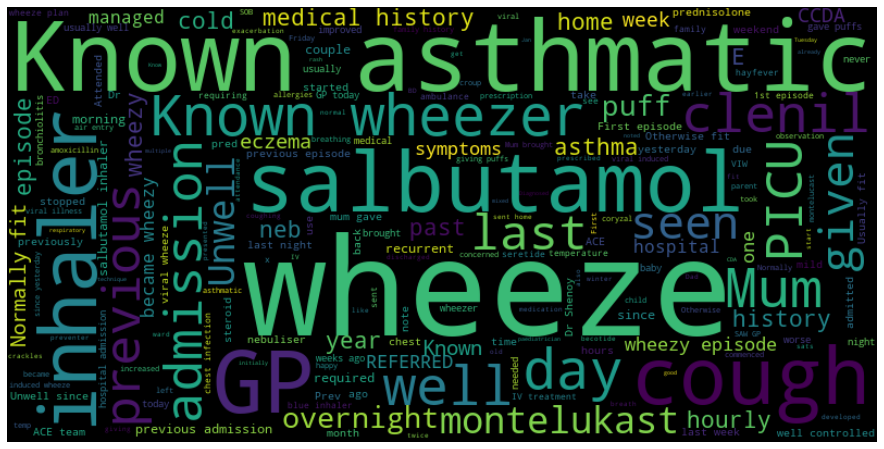

In [3]:
show_wordcloud(ace_dat.medical_history)

### Examination Summary:

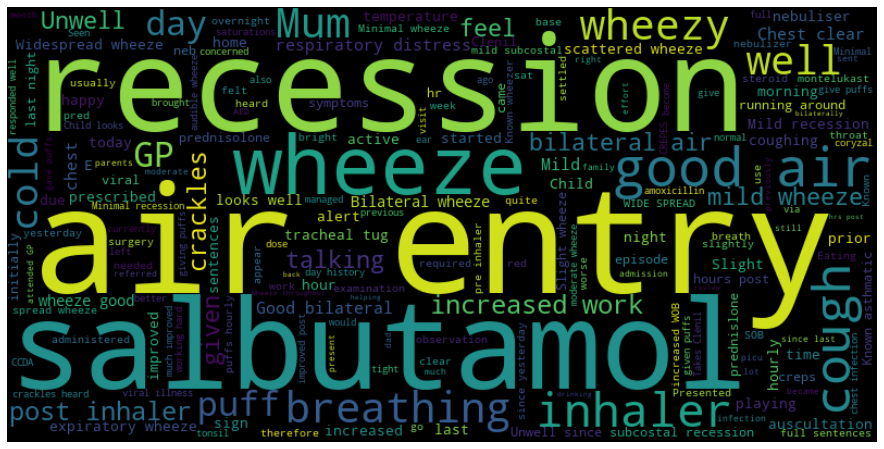

In [4]:
show_wordcloud(ace_dat.examination_summary)

### Recommendation:

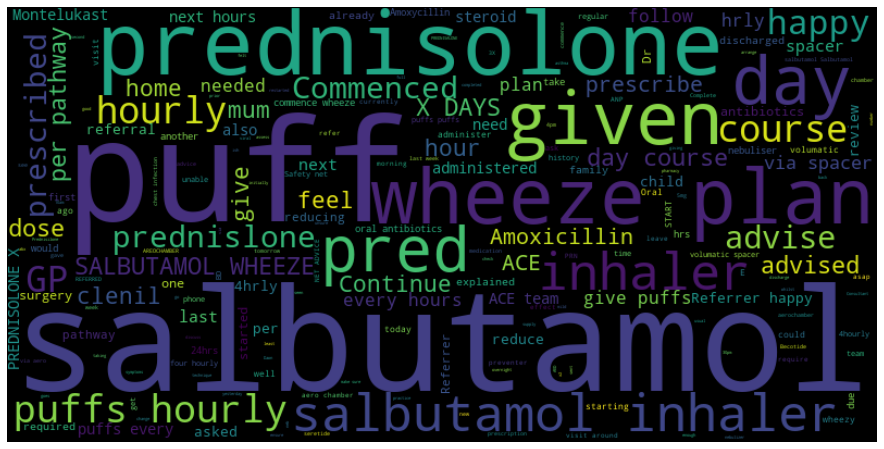

In [5]:
show_wordcloud(ace_dat.recommendation)

The word clouds should be self-explanatory - we quickly get an impression
 for the words that most frequently appear in each of the text features. As
 an analytical tool though, they're a pretty imprecise way of representing
 the data. As such, we won't spend any more time on them, other thant to note
  that we've introduced an idea we can use to analyse the text numerically -
  comparing the relative frequency of terms.

## Bag of Words

The most common way of numerically representing text data is to consider it a
 collection of different words taken from a common vocabulary, a so called
 "bag of words". As a simple example, imagine we took a vocabulary of 10
 words - **The, Cat, Dog, And, Sat, Caught, Ball, Mat, On, With"**. - and
the following sentences - **"The cat sat on the mat"** and **"The dog caught
the ball and sat on the mat with the cat"**. We can represent both sentences
in vector form as simple counts of each word that appears in them:

    vocab vector = [The, Cat, Dog, And, Sat, Caught, Ball, Mat, On, With]

    sentence 1 = [2, 1, 0, 0, 1, 0, 0, 1, 1, 0]

    sentence 2 = [4, 1, 1, 1, 1, 1, 1, 1, 1, 1]

So we now have a way to represent our text in a fixed numerical format; it
is somewhat crude, given that words aren't considered to have any context,
but doing so allows us to statistically analyse the text in the same way we
would with structured data.

There are many things to take account of when processing text in this format,
 so we'll divide them between the stages of pre-processing the text and
 building vectors from it:


### Vocabulary:

When representing our text features in vector form, we need to start with a
common vocabulary. There are several important decisions to be made when
creating this vocabulary, including:

* **Size**: The ACE text contains many thousands of unique words. The more
words we have in our vocabulary, the larger the text vectors need to be, and
the more complex the analysis becomes. Besides which, some words
only appear once and so don't add much to the overall statistical analysis.
As such, it's typical to set a fixed size vocabulary to limit complexity.
* **Stopwords**: As we already discussed above, certain common words don't
really have any meaning on their own, other than gramatical context - for example,
and, it, they, etc. It is useful to build a list of such words to remove from
 your vocabulary, ensuring your counts aren't dominated by meaningless
 prepositions / conjunctions etc.
* **Word Variations:** note the number of synonyms or very closely related words
 that appear in each feature. A good examples are "wheeze" / "wheezy" or "asthma" /
 "asthmatic". Frequently mentioned concepts may be masked by multiple different
 phrasings. It may be better to group these like terms, so we aren't
 fragmenting our counts and missing really prominent concepts / features.
* **N-Grams**: We need not only consider single words when building a
vocabulary. We can also consider pairs or threes (or more) of words that may
have important meanings in context with one another - we already saw promenent
examples of these in the word clouds above, like "viral wheeze" and "air
entry". This must, of course, be balanced with the desired size of the
vocabulary, as adding additional groped terms can cause the vocabulary to
grow exponentially.

Considering the above, we'll be using a common set of stopwords defined by a
popular Python NLP library (NLTK), and we'll use a preprocessing technique
called "stemming". Stemming cuts common endings from words
reducing them to a common root e.g. "preparations" / "preparing" -> "prepar".

The end result of preprocessing will look like this, the sentence:

*"Recurrent wheezy episodes especially over the last 3 month. Older sister
has asthma No other medical history"*

Becomes:

*"recurr wheez episod especi last 3 month older sister asthma medic histori"*

A sentence that doesn't really make much sense out of context, but that's
exactly how were representing our text - counts of words taken out of their
context.

### Vectorising the Text

Now that we have a common vocabulary, we can get to creating vectors to
represent our text. There are, however, some more important considerations:

* **Length of text**: if we just use plain counts like we did above, our
estimates of the importance of words will be biased towards longer sentences
as, the longer a sentence is, the more likely it is to feature greater counts
 of each word.


* **Common / Frequent Terms**: Though we have already removed some
"stopwords" we still have many words that will appear in almost all of the
entries, and therefore won't be significant when comparing entries. Think
words like "patient" and "treatment"; these are likely to be ubiquitous in this
setting and are therefore unlikely to be as helpful in distinguishing between
different notes. Compare this to words like "asthma" and drugs like
"salbutamol"; these aren't as likely to appear in every note (given each
patient's medical history) and so have important meaning when they do.

The first issue is pretty easy to account for: we can just calculate the
relative frequencies for each word rather than plain counts. The second issue
 is more complex and is typically addressed using a technique called TF-IDF, short for
"term frequncy - inverse document frequency".

TF-IDF is a way of accounting for the "importance" of words within text that is taken
from a wider "corpus" of texts. We take the relative frequency of each word
in one of our notes, and divide it by the inverse frequency of that word as
it appears in all the other notes (the corpus). The end result is a score for
 each word that reflects it's relative "importance" in that particular piece
 of text -
  so the appearance of the word "patient" in a note is considered less
  important than the word "salbutamol", given that "patient" is much more
  common in all the other notes as a whole.

## Basic TF-IDF Analysis:

With the theory out of the way, let's take a look at the TF-IDF scores for
each of the different text features. We'll divide the dataset into patients
that were successfully treated by ACE and those that needed hospital
treatment, and then look at the words that produce the 10 highest average TF-IDF
 scores. These can be thought of as the words that are, on average, most
 important to each note divided into the respective successful / unsuccessful
 ACE treatment groups:

In [6]:
# plot the words with highest tf-idf scores from each of the text features
# by examples requiring hospital treatment / successfully treated in ace

fig = make_subplots(
    rows=3, cols=2,
    specs=[[{}, {}], [{}, {}], [{}, {}]],
    subplot_titles=["Medical History:", "",
                    "Examination Summary:", "",
                    "Recommendation:", ""],
    vertical_spacing=0.06,
    horizontal_spacing=0.2
)

text_features = ["medical_history", "examination_summary", "recommendation"]

for feature_idx, text_feature in enumerate(text_features):
    vocab_df = return_vocab_df(X_train[text_feature], y_train)
    for score_idx, score in enumerate(["ace_score", "hosp_score"]):
        if score == "ace_score":
            marker_color = "green"
            score_name = "Successful Treatment"
        else:
            marker_color = "red"
            score_name = "Hospital Admission"

        top_10 = vocab_df.sort_values(score + "_mean", ascending=False).iloc[1:21]
        showlegend = feature_idx == 0
        name = score
        bar_chart = go.Scatter(y=top_10["word"],
                           x=top_10[score + "_mean"],
                           error_x=dict(type="data",
                                        array=top_10[score + "_sem"].values,
                                        visible=True),
                           orientation="h",
                           mode="markers",
                           marker_color=marker_color,
                           showlegend=showlegend,
                           name=score_name,
                           meta={"title_x":0})
        if showlegend:
            fig.update_layout(legend=dict(
                yanchor="top",
                y=1.05,
                xanchor="right",
                x=1,
                bordercolor="black",
                borderwidth=1,
                bgcolor="#e5ecf6"
            ))
        fig.add_trace(bar_chart, row=feature_idx+1, col=score_idx+1)
        fig.update_xaxes(range=[0,0.1])

fig.layout.annotations[0].update(x=0, y=1.01)
fig.layout.annotations[1].update(x=0 , y=0.66)
fig.layout.annotations[2].update(x=0, y=0.31)
fig.update_layout(width=800,
                  height=1500,
                  margin=dict(
                      t=130
                  ),
                  title={"text": "Top 10 Average TF-IDF Word Scores by Text "
                                 "Feature",
                         "x":0.5,
                         "y":0.98,
                         "font":{"size":20},
                         "yanchor": "top",
                         "xanchor": "center"}),
fig.show()

Now we can see the benefit of representing our text entries numerically - we
have a means to more precisely compare different entries. We can clearly see
there are some significant differences between the notes for patients treated
successfully by ACE, and those that needed hospital treatment. For example:

* "salbutamol" features demonstrates a strong relationship with the need for
hospital treatment in each of the different text features
* "previous" and bigrams featuring the word "previous" in the medical history
 feature correlate strongly with the requirement for hospital treatment
* "good" and bigrams including "good" feature strongly in the examination
summaries of children successfully treated by ACE

Whilst these results are certainly more useful than the word cloud, there are
 still some issues:

* Many of the highest scoring words / bigrams feature in both the notes for
children requiring hospital treatment and those that don't. It would be
useful to have a way to filter these out
* The variance in scores (signified by the error bars) is very high. This is
certainly typical of the dataset as a whole given the small number of
examples that require hospital treatment. But this also indicates that
several examples from both groups may deviate significantly from these results

What we really need is a way to link the distribution of different
words directly with the need for hospital treatment / succesful treatment by
ACE. Thankfully this is as simple as fitting a logistic regression to the
TF-IDF scores with an "L1" or "lasso" loss function, as we did previously
with the structured ACE data. As a reminder, the lasso loss function
restricts the number of features the model is able to use to make a
prediction - particularly necessary in this setting as we have a vocabulary
of 500 words, so we don't want to be interpreting 500 different weights!

## Lasso Logistic Regression Analysis

We'll fit individual logistic regression models to each of the vectorised text
features, using them to predict the risk of hospital treatment - we can then
check the nonzero coefficients of these models to see which words they are
using to make their predictions:

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pd.set_option("display.max_columns", None)

fig = make_subplots(
    rows=3, cols=1,
    row_heights = [1, 1,11],
    specs=[[{}], [{}], [{}]],
    subplot_titles=["Medical History:",
                    "Examination Summary:",
                    "Recommendation:"],
    vertical_spacing=0.15
)

clf = LogisticRegression(class_weight="balanced",
                         random_state=0,
                         max_iter=10000,
                         penalty="l1",
                         solver="liblinear")
param_grid = {'C': np.linspace(0.01, 1, 100)}

# train individual sparse (lasso) logistic regression models that classify
# examples requiring hospital treatment using only tf-idf vectors for text
# features
clf_train_scores = pd.DataFrame([])
for feature_idx, feature in enumerate(text_features):
    feature_vecs, feature_processor = process_text(X_train[feature]
                                                   .values)
    grid_search = GridSearchCV(estimator=clf,
                               param_grid=param_grid,
                               n_jobs=-1,
                               cv=3,
                               refit="f1",
                               scoring=scoring)
    grid_search.fit(feature_vecs ,y_train)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    best_cv_results = cv_results[cv_results.rank_test_f1 == 1].iloc[0]
    best_cv_results.name = feature
    clf_train_scores = pd.concat([clf_train_scores,
                                  best_cv_results], axis=1)

    best_clf = grid_search.best_estimator_

    coefs = best_clf.coef_
    nonzero_coef_idxs = np.nonzero(coefs)[1]
    vocab_words = np.array(
        feature_processor["vectorizer"].get_feature_names()
    )
    coefs_df = pd.DataFrame(dict(
        word = vocab_words[nonzero_coef_idxs],
        value = coefs[0, nonzero_coef_idxs]
    )).sort_values("value")

    bar_chart = go.Bar(y=coefs_df.word,
                       x=coefs_df.value,
                       orientation="h",
                       name=feature)
    fig.add_trace(bar_chart, row=feature_idx+1, col=1)


fig.layout.annotations[0].update(x=0, y=1.02)
fig.layout.annotations[1].update(x=0, y=0.81)
fig.layout.annotations[2].update(x=0, y=0.61)

fig.update_layout(width=1000,
                  height=750,
                  showlegend=False,
                  title={"text": "Logistic Regression Coefficient Values by "
                                 "Text Feature",
                         "x":0.5,
                         "y":0.98,
                         "font":{"size":20},
                         "yanchor": "top",
                         "xanchor": "center"})
fig.update_xaxes(range=[-2.5, 2.5])
fig.show()

In [20]:
images_dir = '/Users/samrelins/Documents/LIDA/ace_project/written_work/report/images'
text_coeffs_path = os.path.join(images_dir,"text-coefficients.jpg")
fig.write_image(text_coeffs_path, scale=15, format="jpg")

Great! We now know which words correlate directly with successful ACE
treatment or hospital treatment - the words with positive
 coefficients indicate they are predictive of the need for hospital
 treatment, and negative successful ACE treatment. The relationships here
 should are fairly plain, particularly for medical history and examination
 summary: these two models have highlighted only "asthma" / "known astma(tic)"
 (in the case of medical history) and "salbutamol" (in the case of
 examination summary) as correlated with a greater likelihood of hospital
 treatment. These results could be interpreted in plain english as:

    "A prior history of asthma, and / or treatment with salbutamol during
    the present episode of wheeze, are indicative of a greater risk of
    hospital treatment".

It's also important to consider how accurate the predictions of these models
are against holdout validation data that it hasn't seen during training.
Let's take a look at the cross validation scores for each model:

In [8]:
index_names = [
    'mean_test_f1',
    'std_test_f1', 'mean_test_roc_auc',
         'std_test_roc_auc',
 'mean_test_accuracy', 'std_test_accuracy', 'mean_test_recall',
 'std_test_recall', 'mean_test_precision', 'std_test_precision',
 'mean_test_true_pos', 'std_test_true_pos', 'mean_test_true_neg',
 'std_test_true_neg', 'mean_test_false_pos', 'std_test_false_pos',
 'mean_test_false_neg', 'std_test_false_neg']
clf_train_scores.loc[index_names,:]


medical_history examination_summary recommendation
mean_test_f1               0.184517            0.339331       0.118117
std_test_f1                0.131118            0.009699       0.036550
mean_test_roc_auc          0.539235            0.604335       0.454375
std_test_roc_auc           0.030134            0.007344       0.015012
mean_test_accuracy         0.751331            0.736069       0.659248
std_test_accuracy          0.062330            0.029670       0.069019
mean_test_recall           0.222222            0.407407       0.148148
std_test_recall            0.157135            0.026189       0.069290
mean_test_precision        0.158385            0.293531       0.104815
std_test_precision         0.113598            0.025707       0.015617
mean_test_true_pos         4.000000            7.333333       2.666667
std_test_true_pos          2.828427            0.471405       1.247219
mean_test_true_neg        77.666667           72.666667      69.000000
std_test_true_neg          9.741093            4.027682       8.981462
mean_test_false_pos       13.000000           18.000000      21.666667
std_test_false_pos         9.416298            3.559026       8.576454
mean_test_false_neg       14.000000           10.666667      15.333333
std_test_false_neg         2.828427            0.471405       1.247219

These results aren't fantastic. The medical history and reccomendation
classifiers aren't identifying many examples that require hospital treatment
correctly. The medical history scores show very high variance, so it
seems some of the data splits scored much higher than others. We do seem to have
identified some correlation between these text features and the risk of
hospital admission, however, and so we may be able to add these to add these
features to the original dataset to increase overall accuracy.

It isn't wise to use the TF-IDF values themselves however...

## The Problem with TF-IDF Features (in this context)

A key issue with the TF-IDF scores we are currently using as text features is
 their lack of "robustness", which leads to some extreme variance in the
 models trained using them. By lacking "robustness", we mean that only slight
 changes in the wording can have dramatic effects on the TF-IDF scores. This concept is
  perhaps best exemplified by comparing the robustness of different features in the ACE dataset:

* Features like "age" or "address" are robust - they don't
  change depending on who observes them and are (hopefully!) not subject to any
   measurement error
* The continuous features like "heart_rate" and "ox_sat" are slightly less
robust - they vary with measurement error, possibly different times at which the
recordings are measured, or even different rounding principles used by the
clinician. These variances, however, are likely to be relatively small and
shouldn't dramatically affect the usefulness of this information in statistical
analysis
* TF-IDF scores taken from the text features are not at all robust. They vary
 dramatically based on the exact content of the entries, even if the meaning
 is the same. They are extremely sensitive to numerous different elements of
 the text, such as the different styles of writing between different
 clinicians, brevity / detail of notes, use of synonyms (e.g. "salbutamol
 inhaler" / "blue inhaler"), misspellings, different interpretations of the
 type of
 information to put in each field, and so on...

Moreover, if we were to explain predictions of hospital admission risk using
TF-IDF scores it might look something like:

    "75% risk of hospital treatment because the clinician wrote the word
    "asthma" 3 times, and a total of 23 words in the medical history field"

which isn't a very compelling conclusion to have drawn! That isn't to say
that all the work to this point is useless - we've seen some interesting
relationships between key words in the text features and the risk of hospital
 treatment. The job now is to convert these relationships into new features
 and see if these relationships are useful in combination with the original
 data.

## Desigining New Features From the Text Data

What we need now are some robust features guided by the TF-IDF analysis above.
The easiest and most simple starting point is to have a feature for each of
the keywords identified by the TF-IDF models, and simply indicate if that
 keyword is present in the relevant note with a True / False or 1 / 0 input.
 For the sake of simplicity, we'll reduce the features from the
 recommendation field to only the single words with scores greater than 0.2 i
 .e. "prednisolon", "review", "spacer", "inhal", "commenc", "everi",
 "aerochamb".

Once we've created these features, we can again train a lasso logistic
regression model that will discriminate among the features to identify only
those that correlate best with the need for hospital treatment, and then
evaluate the results of the model to see if the predictions improve. As a
baseline for comparison, we'll start by training a model using the structured data
 from the ACE dataset, without any extra text features:

### Lasso Model without Extra Text Features:

In [9]:
from sklearn.linear_model import LogisticRegression


best_clf = grid_search.best_estimator_
best_orig_scores, best_orig_params = param_search_classifier(
    X_train=X_train.drop(text_features, axis=1),
    y_train=y_train,
    clf=LogisticRegression(random_state=0,
                           max_iter=1000,
                           solver="saga",
                           class_weight="balanced",
                           penalty="l1",
                           n_jobs=-1),
    param_grid={'C': np.linspace(0.01, 0.5, 50)},
    scaled=True,
    verbose=False
)

X_train_prepped_orig, X_test_prepped_orig = encode_and_scale(
    X_train=X_train.drop(text_features, axis=1),
    y_train=y_train,
    X_test=X_test.drop(text_features, axis=1),
    cat_encoder="one_hot",
    scaled=True
);

orig_log_reg_clf = LogisticRegression(
    random_state=0,
    max_iter=1000,
    solver="saga",
    penalty="l1",
    class_weight="balanced",
    n_jobs=-1,
    **best_orig_params
).fit(X_train_prepped_orig, y_train)

display(HTML("<h3 style='padding: 20px 0px 20px 0px'>"
             "Original Dataset - Logistic Regression Classifier "
             "Scores:</h3>"))
display(pd.DataFrame(best_orig_scores, index=["score"]).T)

score
mean_f1          0.271812
std_f1           0.032553
mean_roc_auc     0.536508
std_roc_auc      0.032940
mean_accuracy    0.573423
std_accuracy     0.058833
mean_recall      0.481481
std_recall       0.094426
mean_precision   0.191432
std_precision    0.025797
mean_true_pos    8.666667
std_true_pos     1.699673
mean_true_neg   53.666667
std_true_neg     7.760298
mean_false_pos  37.000000
std_false_pos    7.348469
mean_false_neg   9.333333
std_false_neg    1.699673

The test scores for this classifier are, as we have seen before, reasonable
when compared to the other classifiers we've seen. We'll also quickly take a
look at the coefficient scores, so we can see the features the model is using
 to make its predictions:

In [10]:
import plotly.express as px

orig_coefs = orig_log_reg_clf.coef_
nonzero_coef_idxs = np.nonzero(orig_coefs)[1]
features = X_train_prepped_orig.columns
nonzero_coefs = pd.DataFrame(
    dict(feature=features[nonzero_coef_idxs],
         coefficient_value = orig_coefs[0, nonzero_coef_idxs])
).sort_values("coefficient_value", ascending=False)

bar_chart = px.bar(nonzero_coefs,
                   y="feature",
                   x="coefficient_value",
                   orientation="h")
bar_chart.update_layout(width=800, height=600)
bar_chart.show()


Now we'll add simple text features that indicate the presence or abscence of
different keywords:

In [11]:
def add_free_text_features(dataf):

    simple_text_features = {
        "medical_history": ["asthma", "know asthma"],
        "examination_summary": ["salbutamol"],
        "recommendation": ["spacer", "review", "prednisolon", "inhal", "commenc",
                           "aerochamb", "everi"]
    }

    def find_token(token, text):
        preprocessed_text = ace_text_preprocessor(text)
        return "y" if token in preprocessed_text else "n"

    for text_feature, tokens in simple_text_features.items():
        for token in tokens:
            new_feature_name = text_feature + "_" + "_".join(token.split())
            dataf[new_feature_name] = dataf[text_feature].apply(
                lambda text: find_token(token, text)
            ).astype("category")
    dataf.drop(["medical_history",
                "examination_summary",
                "recommendation"],
               axis=1, inplace=True)

    return dataf

X_train_w_text = X_train.pipe(add_free_text_features)
X_test_w_text = X_test.pipe(add_free_text_features)

best_scores_w_text, best_params_w_text = param_search_classifier(
    X_train=X_train_w_text,
    y_train=y_train,
    clf=LogisticRegression(random_state=0,
                           max_iter=1000,
                           solver="saga",
                           class_weight="balanced",
                           penalty="l1",
                           n_jobs=-1),
    param_grid={'C': np.linspace(0.01, 1, 50)},
    scaled=True,
    verbose=False
)

X_train_prepped_w_text, X_test_prepped_w_text = encode_and_scale(
    X_train=X_train_w_text,
    y_train=y_train,
    X_test=X_test_w_text,
    cat_encoder="one_hot",
    scaled=True
);

log_reg_clf_w_text = LogisticRegression(
    random_state=0,
    max_iter=1000,
    solver="saga",
    penalty="l1",
    class_weight="balanced",
    n_jobs=-1,
    **best_params_w_text
);

log_reg_clf_w_text.fit(X_train_prepped_w_text, y_train);
test_scores_w_text = score_classifier(log_reg_clf_w_text,
                                      X_test_prepped_w_text, y_test);
display(HTML("<h3 style='padding: 20px 0px 20px 0px'>"
             "Extra Text Features - Logistic Regression Classifier "
             "Scores:</h3>"))
display(pd.DataFrame(test_scores_w_text, index=["score"]).T)

score
f1          0.211765
roc_auc     0.485185
accuracy    0.586420
recall      0.333333
precision   0.155172
true_pos    9.000000
true_neg   86.000000
false_pos  49.000000
false_neg  18.000000

The classifier trained with the original ACE dataset features and additional
text features actually performs worse than the model with the original
features alone. Lets take a quick look at the coefficients to see which
features it's using:

In [12]:
coefs_w_text = log_reg_clf_w_text.coef_
nonzero_coefs_w_text_locs = np.nonzero(coefs_w_text)[1]
features_w_text = X_train_prepped_w_text.columns
nonzero_coefs_w_text = pd.DataFrame(
    dict(feature=features_w_text[nonzero_coefs_w_text_locs],
         coefficient_value = coefs_w_text[0, nonzero_coefs_w_text_locs])
).sort_values("coefficient_value", ascending=False)

bar_chart = px.bar(nonzero_coefs_w_text,
                   y="feature",
                   x="coefficient_value",
                   orientation="h")
bar_chart.update_layout(width=800, height=400)
bar_chart.show()

Note: "recomendation_inhal_y" indicates that the recommendation text includes
 the word "inhaler", likewise "medical_history_asthma_y" indicates the
 medical history text contains the word "asthma", and so on

The model is using several of the new text features, indicating that they
correlate strongly with hospital admissions. The drop in accuracy here is
almost definitely down to overfitting. The text features offer a better fit
to the training data, but the chosen coefficients don't generalise well when
making predictions on unseen examples in the validatino data.

## Further Exprerimentaion

I've experimented engineering a number of more complex text features,
examples of which are:

* Stricter definitions of "taking a certain drug" that account for phrases like "on
 salbutamol" or "taking prednisolone" but ignoring negative statements like
 "not taking montelukast"
* Similar definitions of "asthma" and "wheeze" that indicate mentions of
"previouis episodes of" and the like whilst ignoring statements like "**no**
previous episodes of"
* Mentions of "poor inhaler technique" that have featured in several notes,
and that mat has indicated in the past might be predictive of hospital admission

Despite these efforts, none of these features have shown a stronger
correlation with hospitalisation than the simple features already studied,
and any that do show correlation also suffer from the same overfitting issues.

I have also returned to the suite of models that were tested with the
original dataset, and have re-trained them adding these additional text
features. Unfortunately, none of the models show dramatically better
performance than the results we've already seen with the logistic regression
model.

These experiments have also highlighted another issue that we have seen a
number of times before:

## Variance of Results:

Whilst experimenting with the text data, I've noted that only small changes
in either the random divisions of training and validation data, or small
differences in parameters have huge effects on the predictive accuracy of
these models. As such, the above results can't be considered replicable
outside of the very specific parametarisation used in this notebook and
supporting source code.

This variance in results caused me to reconsider whether they significant
enough to report at all. However, throughout my numerous experiments the
words highlighted above were shown to correlate with hospitalisation outcomes
 time and again. I did attempt to quantify these variances and better
 represent the different results found throughout these experiments, but
 haven't been able to find a manageable methodology to do so.

## Conclusion

The analysis of the text features has shown some promising correlation
between features in the text and the need for hospitalisation. This is
difficult to validate however, given the extreme variance in results seen
during experimentation and even during cross validation of the models above. As
such, I see the results here as an indication of the types of features in the
 primary care data that may be good predictors. We can expect such featueres
 to be more robust, given that they are likely to me more accurately and
 consistently recorded than the free-text data we've seen.

## Engineering features from Asthma / Salbutamol coefficients

The below are a couple of simple helper functions to create "mentions" features for the mentions of "asthma" in the medical histories and "salbutamol" in the examination summaries. Unlike the above analyses, these features are able to identify negations i.e. "not asthmatic", "salbutamol not prescribed" and does not count them among the mentions:

In [13]:
def positive_mention_in_phrase(word, text):
    hit = False
    if word in text:
        match_not = re.search(r"\bnot?\b", text)
        if match_not:
            not_end_pos = match_not.span()[1]
            word_start_pos = re.search(word, text).span()[0]
            gap = word_start_pos - not_end_pos
            if gap < 1 or gap > 50:
                hit = True
        else:
            hit = True
    return hit

def mentions_asthma(note):
    for phrase in re.split(r"[\n.,-]", note.lower()):
        if positive_mention_in_phrase("asthm", phrase):
            return True
    return False


def mentions_salbutamol(note):
    for phrase in re.split(r"[\n.,-]", note.lower()):
        if positive_mention_in_phrase("salbut", phrase):
            return True
        elif "post" in phrase and "salbut" in phrase:
            return True
    return False

In [14]:
crude_asthma = ace_dat.medical_history.apply(
    lambda note: True if "asthm" in note.lower() else False
)

better_asthma = ace_dat.medical_history.apply(mentions_asthma)

In [17]:
crude_salbut = ace_dat.examination_summary.apply(
    lambda note: True if "salbut" in note.lower() else False
)

better_salbut = ace_dat.examination_summary.apply(mentions_salbutamol)
